# Extending The SEIR Model: A Monte Carlo Study

## Model Definition

The SEIR model is a standard mathematical model from epidemiology for modeling the outbreak of an infectious disease in a given population. The basic model consists of four states - suceptible (S), exposed (E), infectious (I), and removed (R). A susceptible individual becomes exposed to the virus through contact with infectious individuals, and so progresses from S to E. At disease onset the individual moves to state I, and upon recovery or death they move to R. Model parameters determine the rate of transfer between each state.

The SEIR model can be extended by including additional states and parameters which help to more fully capture the complexity of a particular outbreak. One example of this kind of extended SEIR model is presented in [Kissler et al. 2020](https://www.medrxiv.org/content/10.1101/2020.03.22.20041079v1.full.pdf). Their model stratifies cases by severity - that is, after exposure an individual either becomes a mild/asymptomatic, severe, or critical case. Mild/asymptomatic cases require no hospitalization, severe cases require hospitalization but no critical care, and critical cases require hospitalization including critical care. Mild/asymptomatic cases move straight from the infectious state to the removed state. Severe cases move from the infectious state to the non-critical hospitalization state, then to removed. Critical cases move from the infectious state to hospitalization, to ICU, to removed.

The states, paths, and parameters for the Kissler model are depicted here (diagram and table directly from the paper):

<img src="images/diagram.png" width=600>
<img src="images/parameters.png", width=600>

## Notebook Objectives

In this notebook we do the following:
1. Implement the model from the Kissler paper
2. Extend the model by treating parameters as random variables
3. Use monte carlo methods with the stochastic model to generate a more robust forecast

In [333]:
# import necessary libraries
import json
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as R

## Note

Each different model is represented as a class, where each class follows the "model interface". The way you interface with a model is:

1. initialize the model with a set of initial conditions
2. run the model (and get back statistics)
3. visualize the simulated data

where "running the model" consists of
1. (optionally) draw at random from each parameter distribution
2. run the simulation
3. compute statistics from the simulated data

In [323]:
class KisslerParameters():
    '''handles sampling from parameter distributions'''
    
    def __init__(self):
        self.vals = {}
    
    def draw(self):
        """assign value to each model parameter by drawing from that parameter's distribution"""
        
        self.vals = {
            "phi": -26.6, # what to do here
            
            "maxR0": self.drawR0(), 
            "seasonal": self.drawSeasonal(),   
            "v": 1/self.drawIncubation(),        
            "gamma": 1/self.drawInfectious(),                               
            "deltah": 1/self.drawLOSNoCritical(), 
            "deltac": 1/self.drawLOSPreCritical(),            
            "xic": 1/self.drawLOSCritical()                                  
        }
        
        self.vals["pr"], self.vals["ph"], self.vals["pc"] = self.drawStrataFreqs()
        
    def drawR0(self):
        '''the basic reproductive number'''
        return R.uniform(2,2.5)
        
    def drawSeasonal(self):
        '''size of effect of seasonal forcing'''
        return R.triangular(.7,.8,1)
    
    ## NOTE: the weibull distributions are shifted so as to
    ## begin at 1 rather than 0, since these rate parameters
    ## cannot have values smaller than the size of the model timestep
    ## this ensures that the signal between states is never amplified
    ## e.g., 5 people in exposed -> 7 people become infectious
    ## this is an impossible situation in reality,
    ## and it is avoided in the model by this shifting of these distributions
    
    def drawIncubation(self):
        '''exposure to onset'''
        return R.weibull(2.16)*4.1 + 1
        
    def drawInfectious(self):
        '''length of infectious period / onset to hospitalization'''
        return R.weibull(1.8)*3.37 + 1
    
    def drawLOSNoCritical(self):
        '''length of hospital stay with no visit to the ICU'''
        return R.weibull(3.88)*7.78 + 1
    
    def drawLOSPreCritical(self):
        '''length of hospital stay prior to transfer to ICU'''
        return R.weibull(1.31)*5.39 + 1
    
    def drawLOSCritical(self):
        '''duration of critical care'''
        return R.weibull(3.76)*9.98 + 1
    
    def drawStrataFreqs(self):
        '''relative frequency of each stratum - mild / severe / critical'''
        
        # draw percentages
        mild = R.triangular(75,80,85)
        severe = R.triangular(12,13.8,15)
        critical = R.triangular(3,4.7,6)

        # scale
        total = mild + severe + critical
        m, s, c = mild / total, severe / total, critical / total
        
        return m, s, c

In [324]:
class KisslerModel:
    """
    this class implements the Kissler model;
    see: https://www.medrxiv.org/content/10.1101/2020.03.22.20041079v1.full.pdf
    
    follows the 'model' interface:
    
        kissler = KisslerModel(initVals)
        stats = kissler.run()
        kissler.visualize()
    
    using the model interface facilitates MCMC methods:
    
        trials = []
        for i in range(1000):
            model = drawModel(initialConditions)
            stats = model.run()
            trials.append(stats)
            
        results = mean(trials)
        return results
        
    """
    
    # list all states of the model
    states = [
        "S",
        "E",
        "Ir", "Rr",
        "Ih", "Hh", "Rh",
        "Ic", "Hc", "Cc", "Rc"
    ]
    
    def __init__(self, initVals=None, nSteps=150):
        
        # store provided number of timesteps to simulate - default is 100 days
        self.nSteps = nSteps
        
        # store provided initial values for each state
        # Q. Should it be optional to specify initial values?
        # ---> could just define a sensible default initial state
        self.initVals = initVals
        
        # store param values after draw
        self.params = KisslerParameters()
        
        # store per-state time-series generated by model run 
        self.simulation = {}
        
        # store statistics computed from simulation data
        self.stats = {}
        
    def runMonteCarlo(self, n):
        simulations = []
        statistics = []
        for i in range(n):
            model = KisslerModel(self.initVals)
            model.run()
            simulations.append(model.simulation)
            statistics.append(model.stats)

        # average the statistics
        self.stats = pd.DataFrame(statistics).mean()
        
        # average the time-series
        self.simulation = pd.concat(simulations, keys=[i for i in range(n)]).mean(level=1)

    def run(self):
        """
        1. set values to parameters
        2. run the simulation
        3. compute statistics
        """
        
        self.params.draw()
        self.runSimulation()
        self.computeStats()
    
    def setParams(self):
        """
        set param values to fixed (i.e., non-random) values from the paper
        
        NOTE: this fn is not being used
        """
        
        # params specify transition rates between states
        # note: time measured in days
        self.params = {
            "maxR0": 2, "seasonal": .7, "phi": -26.6,  # beta is a cosine fn defined by these params
            "v": .217,                                 # inverse of mean incubation period
            "pr": .956, "ph": .0308, "pc": .0132,      # rel freq of cases mild/asymptomatic, hospitalized, critical care
            "gamma": .2,                               # inverse of mean infectious period
            "deltah": .125, "deltac": .167,            # inverse of mean non-icu hospital stay for hospitalized, critical care
            "xic": .1                                  # inverse of mean critical care duration
        }
        
    def computeStats(self):
        """
        compute statistics of interest from simulation results
            - size of peak
            - time of peak
            - how much of the population gets sick by the end of the outbreak
            - duration of outbreak
            - herd immunity threshold (1 - 1/R0)
                -> see: https://watermark.silverchair.com/cir007.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAlIwggJOBgkqhkiG9w0BBwagggI_MIICOwIBADCCAjQGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMk9OCqPVIv3T5YtV2AgEQgIICBXyGo2h1igPCTwJOPBYsQFpvzpqcCY42-bR1uT59WdeNExXKanT2b0sD_Yrj6V5M9jnSb9mHk-BjGkP7OuiHoU42GGR5z6zoBsDFG6YF0wmhtDRBkQB3f5wInaXlbU_IalYnOqgFEz4NQU3gpZDFysq-AUWicEZFJMiuguEP_iTSpaw6tDHfoxnZiFoeIqQRbg6uGGGh8nKHA4UaSMZ0dqvooNtCzokaJFKL4ceLvu_TZdpqS2mgIH5rc38bLhoZHMQ5uBAN8t_4hlGfnu_o9U1-yZcgicbcQsAp7bTqjoaDvGKTcqTj29YeM-FaP3Zpdr58LmxwUyV2S6R0_KJhH9bwMqNvXNAdqpf4lYsSonzE0IA1QumGASokucYdFSWGPp4Fzzfzn9GU3Wxx-OzdFS8lNCHCgWJkC8Iumnumkhf7BFVp6RBoAxZru04hSB1TMWytuhkeX41bseiWkgux1EGRtclaLNGosCmYHKwOf7hAUvC0UYkSR8HlsUkdPvUzdjiYd1yAt1YYCcz0YNhrDz8HSapdXGb3q09TSeEEqKbv2pRi4GCIxqs_qTeSQHPZj0N28gVjW0AetUWh0p3uzCDRGHUn8nIGOmyUYp_-HV5dT8lhSnjIKJNejSUmtiQNS8iucu18wLbAqVo39eVhq4thObjN0_7hWQTDYMZx1dclGrPQgdQ
            - time at which herd immunity threshold reached
            - time at which 50% of the population is recovered/removed        
        """
        
        infectionStates = [
            "E",
            "Ir",
            "Ih", "Hh",
            "Ic", "Hc", "Cc"
        ]
        
        removedStates = [
            "Rr",
            "Rh",
            "Rc"
        ]
        
        '''
        stats = {
            "peak_size": 0, # max(E + Ir + Ih + Ic + Hh + Hc + Cc)
            "peak_time": 0, # timestep at which 'peak_size' occurs
            "long_run_removed": 0, # (Rr + Rh + Rc) at final timestep
            "outbreak_duration": 0, # timestep (at tail of outbreak) at which (E + Ir + Ih + Ic + Hh + Hc + Cc) < .01            
            "herd_immunity_threshold": 0, # 1 - 1/R0
            "herd_immunity_time": 0, # min(timestep at which (Rr + Rh + Rc) >= herd_immunity_threshold)            
            "half_removed_time": 0 # min(timestep at which (Rr + Rh + Rc) >= .5)
        }
        '''
        
        df = pd.DataFrame.from_dict(self.simulation)
        totalActiveCases = df[infectionStates].sum(axis=1)
        totalRemovedCases = df[removedStates].sum(axis=1)
        
        # peak stats
        peak_size = totalActiveCases.max()
        peak_time = totalActiveCases.idxmax()
        
        # here arbitrarily defining "end of outbreak" as
        # when fewer than 1% of the population are active cases
        outbreak_duration = totalActiveCases[peak_time:].lt(.01).idxmax() + peak_time
        
        # how much of the population will have been infected by the end of the outbreak
        long_run_removed = totalRemovedCases.array[-1]
        
        # first time at which 50% of the population have had the infection
        half_removed_time = totalRemovedCases.ge(.5).idxmax()
        
        # crude estimate - "ballpark"
        herd_immunity_threshold = 1 - 1/self.params.vals["maxR0"]
        herd_immunity_time = totalRemovedCases.ge(herd_immunity_threshold).idxmax()
        
        self.stats = {
            "peak_size": peak_size,
            "peak_time": peak_time,
            "outbreak_duration": outbreak_duration,
            "long_run_removed": long_run_removed,
            "half_removed_time": half_removed_time,
            "herd_immunity_threshold": herd_immunity_threshold,
            "herd_immunity_time": herd_immunity_time
        }
        
    def initStates(self):
        """assign initial relative frequency to each state"""
        freq = {}
        for state in self.states:
            freq[state] = [self.initVals[state]]
        return freq
    
    def runSimulation(self):
        """
        given: 
            - initial conditions set
            - parameter values set
        
        run the simulation
        """
        
        # set initial conditions
        freq = self.initStates()

        # retrieve parameter values
        p = self.params.vals
        maxR0, seasonal, phi = p["maxR0"], p["seasonal"], p["phi"]
        v, pr, ph, pc = p["v"], p["pr"], p["ph"], p["pc"]
        gamma = p["gamma"]
        deltah, deltac = p["deltah"], p["deltac"]
        xic = p["xic"]

        # define beta (the cosine fn) using provided params: maxR0, seasonal, phi
        def betaFunc(j):
            return math.cos((2*math.pi*(j + phi))/364)*maxR0*(1-seasonal)/2 + maxR0*(1+seasonal)/2

        # define increment per state for a given time step
        # increment is the difference between the jth and (j+1)th step
        def increment(j):
            beta = betaFunc(j)
            return {
                "S": -beta*freq["S"][j]*(freq["Ir"][j] + freq["Ih"][j] + freq["Ic"][j]),
                "E": beta*freq["S"][j]*(freq["Ir"][j] + freq["Ih"][j] + freq["Ic"][j]) - v*freq["E"][j],
                "Ir": pr*v*freq["E"][j] - gamma*freq["Ir"][j],
                "Rr": gamma*freq["Ir"][j],
                "Ih": ph*v*freq["E"][j] - gamma*freq["Ih"][j],
                "Hh": gamma*freq["Ih"][j] - deltah*freq["Hh"][j],
                "Rh": deltah*freq["Hh"][j], 
                "Ic": pc*v*freq["E"][j] - gamma*freq["Ic"][j],
                "Hc": gamma*freq["Ic"][j] - deltac*freq["Hc"][j],
                "Cc": deltac*freq["Hc"][j] - xic*freq["Cc"][j],
                "Rc": xic*freq["Cc"][j]
            }

        # simulate the specified number of timesteps
        for t in range(self.nSteps):
            diffEq = increment(t)
            for state in self.states:
                val = freq[state][t] + diffEq[state]
                freq[state].append(val)
        
        
        self.simulation = pd.DataFrame(freq)
        
    def visualize(self):
        """visualize simulated data (and statistics)"""
        fig, ax = plt.subplots()
        fig.set_size_inches(16, 8)

        t = [i for i in range(self.nSteps+1)]
        for state in self.states:
            ax.plot(t, self.simulation[state], label=state)

        ax.set(
            xlabel="days", 
            ylabel="relative frequency", 
            title="relative frequency per state over time"
        )
        ax.legend()
        ax.grid()

        plt.show()
    
    def summarize(self):
        '''view simulation results'''
        # print('COVID-19 Progression:') # -> improve plot presentation, labels, etc.
        self.visualize()
        print('Statistics of Interest:\n')
        print(mcModel.stats.to_string())
        

In [325]:
# set initial conditions

# (assumed fixed) population size
N = 1000000

# initial relative frequency for each state
initVals = {
    "S": 1 - 1/N,
    "E": 1/N,
    "Ir": 0, "Rr": 0,
    "Ih": 0, "Hh": 0, "Rh": 0,
    "Ic": 0, "Hc": 0, "Cc": 0, "Rc": 0
}

In [326]:
# run the model once
model = KisslerModel(initVals)
stats = model.run()

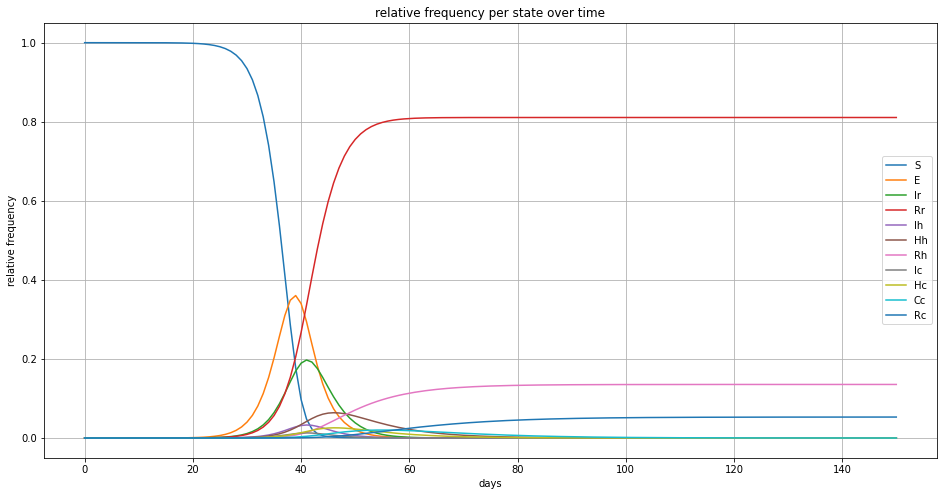

Statistics of Interest:

half_removed_time           47.262100
herd_immunity_threshold      0.553710
herd_immunity_time          48.218800
long_run_removed             0.996432
outbreak_duration          122.440900
peak_size                    0.683556
peak_time                   42.226900


In [327]:
# view results
model.summarize()

In [302]:
# check that you implemented the draws correctly
# view param values, spot check distributions
# implement monte carlo for calculating statistics of interest

In [329]:
# run the model 1000 times
mcModel = KisslerModel(initVals)
mcModel.runMonteCarlo(1000)

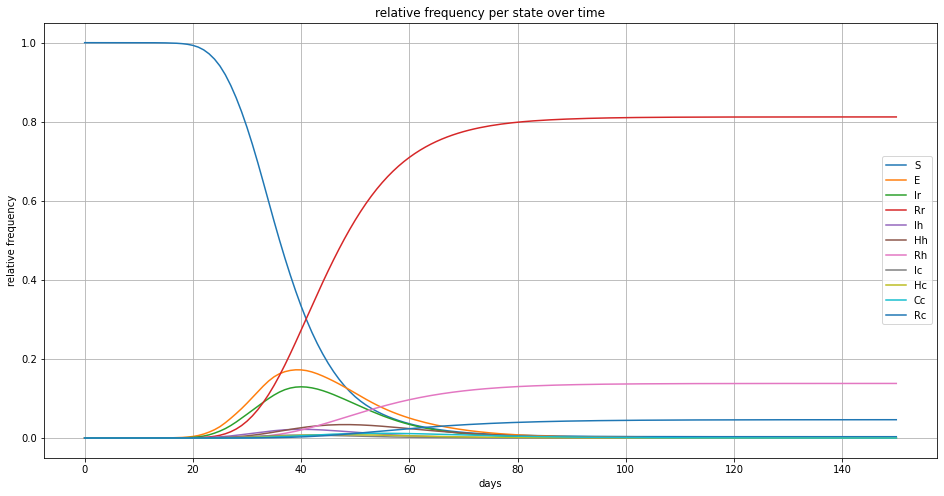

Statistics of Interest:

half_removed_time           47.150000
herd_immunity_threshold      0.553414
herd_immunity_time          48.110000
long_run_removed             0.996587
outbreak_duration          122.347000
peak_size                    0.686995
peak_time                   42.088000


In [330]:
# view results
mcModel.summarize()